In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda, Reshape
from keras.layers.merge import Multiply
from keras.models import Model
from keras.layers.merge import Concatenate, Add
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D, AveragePooling1D
from keras.layers.convolutional import UpSampling1D, UpSampling2D
from keras.regularizers import l2, l1, l1_l2
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.recurrent import LSTM
from keras import backend as K

def set_keras_num_threads(n_threads):
    from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.intra_op_parallelism_threads = n_threads
    config.inter_op_parallelism_threads = n_threads
    K.set_session(tf.Session(config=config))
    
set_keras_num_threads(2)

import tensorflow as tf
import h5py
from Bio import SeqIO
import os
import subprocess

/home/shibinbin/apps/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
cd ..

/home/shibinbin/ibme/projects/Deepfold2


In [4]:
class Onehot(object):
    def __init__(self, alphabet='AUCG'):
        self.alphabet = np.asarray(list(alphabet), dtype='U1')
        
    def encode(self, s):
        x = np.asarray(list(s), dtype='U1')
        encoded = (x[:, np.newaxis] == self.alphabet[np.newaxis, :]).astype(np.int32)
        return encoded

    def decode(self, x):
        return ''.join(self.alphabet[np.argmax(x, axis=1)])

def load_datasets(input_dir, cm_idx):
    datasets = {}
    onehot = Onehot()
    for i, cm_id in enumerate(cm_ids + ['random']):
        dataset = []
        for record in SeqIO.parse(os.path.join(input_dir, cm_id + '.fa'), 'fasta'):
            dataset.append(onehot.encode(str(record.seq))[np.newaxis, :, :])
        dataset = np.concatenate(dataset, axis=0)
        datasets[cm_id] = dataset[:1000, :].copy()
    return datasets

def save_datasets(datasets, filename):
    with h5py.File(filename, 'w') as f:
        for cm_id, dataset in datasets.items():
            f.create_dataset(cm_id, data=dataset.astype(np.int8))

def fasta_to_onehot(filename, motif_only=False):
    '''Read a FASTA file and convert the sequences to onehot encoding
    Args:
        motif_only: parse motif position from sequence name and extract only motif instances
    Returns:
        ndarray of shape (n_sequences, seq_length, alphabet_size)
    '''
    from Bio import SeqIO

    onehot = Onehot()
    dataset = []
    for record in SeqIO.parse(filename, 'fasta'):
        if motif_only:
            start, end = [int(a) for a in record.id.split('/')[1].split('-')]
            start -= 1
            dataset.append(onehot.encode(str(record.seq)[start:end])[np.newaxis, :, :])
        else:
            dataset.append(onehot.encode(str(record.seq))[np.newaxis, :, :])
    lengths = np.asarray([a.shape[1] for a in dataset])
    max_length = np.max(lengths)
    if not np.all(lengths == max_length):
        dataset_container = np.zeros((len(dataset), max_length, 4), dtype=np.int32)
        for i, a in enumerate(dataset):
            dataset_container[i, :a.shape[1], :] = a[0]
        dataset = dataset_container
    else:
        dataset = np.concatenate(dataset, axis=0)
    return dataset

In [18]:
X_motif = fasta_to_onehot('output/rfam_sample/seq/512/5S_rRNA.fa', motif_only=True)
X_motif.shape

(10000, 149, 4)

In [24]:
X_motif.sum(axis=2)[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

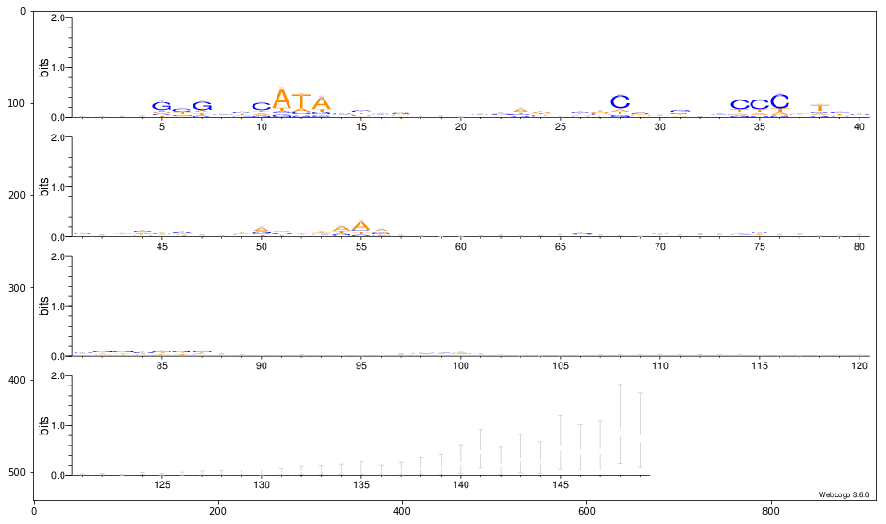

In [21]:
pwm_true = X_motif.sum(axis=0)
weblogo_png = pwm_weblogo(pwm_true, '5S_rRNA')
image_data = plt.imread(BytesIO(weblogo_png))
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(image_data)

In [20]:
pwm_true.shape

(149, 4)

In [5]:
n_classes = 2
with open('metadata/rfam_selected_ids.txt', 'r') as f:
    cm_ids = f.read().split()
    
X = []
y = []
for label, cm_id in enumerate(['random', cm_ids[0]]):
    X_ = fasta_to_onehot('output/rfam_sample/seq/512/{}.fa'.format(cm_id))
    X.append(X_)
    y.append(np.full(X_.shape[0], label))

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
random_indices = np.random.permutation(X.shape[0])

X = np.take(X, random_indices, axis=0)
y = np.take(y, random_indices, axis=0)
# randomly swap some of the labels
swap_indices1 = np.random.choice(X.shape[0], size=5000)
y_shuffled = y.copy()
y_shuffled[swap_indices1] = 1 - y_shuffled[swap_indices1]
# shuffle all y's
#np.random.shuffle(y_shuffled)

In [36]:
def conv_network(input_layer):
    output = Conv1D(64, 12, padding='same', name='conv1', kernel_regularizer=l2(0.001))(input_layer)
    output = Activation('relu', name='relu1')(output)
    output = MaxPooling1D(4, name='maxpool1')(output)
    output = Conv1D(64, 3, padding='same', name='conv2')(output)
    output = Activation('relu', name='relu2')(output)
    output = MaxPooling1D(4, name='maxpool2')(output)
    output = Conv1D(128, 3, padding='same', name='conv3')(output)
    output = Activation('relu', name='relu3')(output)
    output = GlobalMaxPooling1D(name='maxpool3')(output)
    #output = Conv1D(128, 3, padding='same')(output)
    #output = Activation('relu')(output)
    #output = MaxPooling1D(4)(output)
    #output = Flatten()(output)
    return output

class MotifClassifier(object):
    def __init__(self, window_size=512, n_classes=2, n_channels=4):
        input_layer = Input(shape=(window_size, n_channels), name='input')
        output = conv_network(input_layer)
        if n_classes > 2:
            output = Dense(n_classes, name='dense')(output)
            output = Activation('softmax', name='output')(output)
            model = Model(inputs=[input_layer], outputs=[output])
            model.compile(loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'],
                          optimizer='Adam')
        elif n_classes == 2:
            output = Dense(1, name='dense')(output)
            output = Activation('sigmoid', name='output')(output)
            model = Model(inputs=[input_layer], outputs=[output])
            model.compile(loss='binary_crossentropy',
                         metrics=['binary_accuracy'],
                         optimizer='Adam')
        self.model = model

In [38]:
motif_classifier = MotifClassifier(window_size=512, n_classes=2)
motif_classifier.model.summary()
motif_classifier.model.fit(X, y, epochs=10, batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, 4)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 512, 64)           3136      
_________________________________________________________________
relu1 (Activation)           (None, 512, 64)           0         
_________________________________________________________________
maxpool1 (MaxPooling1D)      (None, 128, 64)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 128, 64)           12352     
_________________________________________________________________
relu2 (Activation)           (None, 128, 64)           0         
_________________________________________________________________
maxpool2 (MaxPooling1D)      (None, 32, 64)            0         
__________

In [39]:
def eval_function(f, inputs, batch_size=50):
    n_samples = inputs[0].shape[0]
    output_values = []
    i = 0
    while i < n_samples:
        output_values.append(f([a[i:min(i + batch_size, n_samples)] for a in inputs]))
        i += batch_size
    output_values = [np.concatenate(a, axis=0) for a in zip(*output_values)]
    return output_values

layer = motif_classifier.model.get_layer('conv1')
conv1_kernel = layer.get_weights()[0]
conv1_bias = layer.get_weights()[1]

# get activations of the first conv layer
input_layer = motif_classifier.model.input
relu1 = motif_classifier.model.get_layer('relu1')
relu1_f = K.function([input_layer], [relu1.output])
relu1_values = eval_function(relu1_f, [X])
relu1_threshold = 0.9*np.max(np.max(relu1_values[0], axis=0), axis=0)
activated_filters = np.nonzero(relu1_values[0] > relu1_threshold[np.newaxis, np.newaxis, :])
activated_filter_indices = activated_filters[2]

In [10]:
def counts_to_transfac(counts, name, species_name='unknown', alphabet='ATCG'):
    '''Convert counts to transfac format
    Args:
        counts: ndarray of shape (length, alphabet_size)
    '''
    column_width =  max(int(np.ceil(np.log10(counts.shape[0]))),
                        int(np.ceil(np.log10(np.max(counts)))))
    body_format = '{:0>2d}\t{:<{width}d}\t{:<{width}d}\t{:<{width}d}\t{:<{width}d}'
    header_format = '{:<{width}s}\t{:<{width}s}\t{:<{width}s}\t{:<{width}s}\t{:<{width}s}'
    counts = counts.astype(np.int32)
        
    lines = []
    lines.append('ID {}'.format(name))
    lines.append('BF {}'.format(species_name))
    lines.append(header_format.format('PO', *list(alphabet), width=column_width))
    #lines.append('//')
    for pos, counts_row in zip(range(1, counts.shape[0] + 1), counts):
        lines.append(body_format.format(pos, *counts_row, width=column_width))
    return '\n'.join(lines)

def pwm_weblogo(counts, name, species_name='unknown', alphabet='ATCG', output_format='png'):
    '''Convert counts to WebLogo (SVG format)
    Args:
        counts: ndarray of shape (length, alphabet_size)
    Returns:
        svg script
    '''
    column_width =  max(int(np.ceil(np.log10(counts.shape[0]))),
                        int(np.ceil(np.log10(np.max(counts)))))
    body_format = '{:0>2d}\t{:<{width}d}\t{:<{width}d}\t{:<{width}d}\t{:<{width}d}'
    header_format = '{:<{width}s}\t{:<{width}s}\t{:<{width}s}\t{:<{width}s}\t{:<{width}s}'
    counts = counts.astype(np.int32)
        
    lines = []
    lines.append('ID {}'.format(name))
    lines.append('BF {}'.format(species_name))
    lines.append(header_format.format('PO', *list(alphabet), width=column_width))
    #lines.append('//')
    for pos, counts_row in zip(range(1, counts.shape[0] + 1), counts):
        lines.append(body_format.format(pos, *counts_row, width=column_width))
    transfac = '\n'.join(lines)
    
    p = subprocess.Popen(['weblogo', '-D' 'transfac', '-F', output_format, '-s' 'large'],
                     stdin=subprocess.PIPE,
                     stdout=subprocess.PIPE)
    weblogo_svg, _ = p.communicate(bytearray(transfac, encoding='UTF-8'))
    #weblogo_svg = str(weblogo_svg, encoding='UTF-8')
    return weblogo_svg

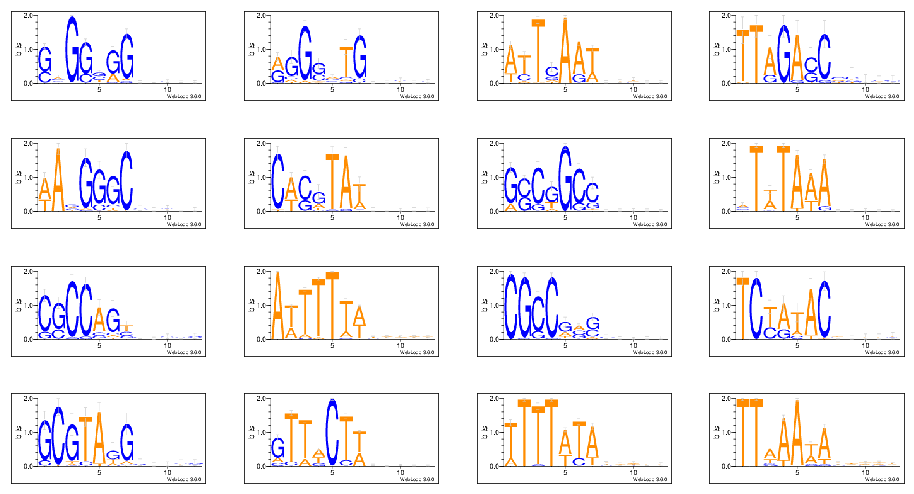

In [41]:
from io import BytesIO
# convert conv filters to PWMs
pwms = np.zeros(conv1_kernel.shape)
for filter_index in range(conv1_kernel.shape[2]):
    filter_mask = (activated_filter_indices == filter_index)
    for i in range(conv1_kernel.shape[0]):
        valid_mask = ((activated_filters[1][filter_mask] + i) < X.shape[1])
        X_activated = X[activated_filters[0][filter_mask][valid_mask],
                        activated_filters[1][filter_mask][valid_mask] + i]
        pwms[i, :, filter_index] = X_activated.sum(axis=0)

fig, axes = plt.subplots(4, 4, figsize=(16, 9))
for i in range(4):
    for j in range(4):
        weblogo_png = pwm_weblogo(pwms[:, :, i*4 + j], name='conv1_1')
        image_data = plt.imread(BytesIO(weblogo_png))
        axes[i, j].imshow(image_data)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

In [110]:
pwms[:, :, 10]

array([[0.00102669, 0.00102669, 0.00102669, 0.99691992],
       [0.00102669, 0.99691992, 0.00102669, 0.00102669],
       [0.16529774, 0.00102669, 0.12525667, 0.70841889],
       [0.00102669, 0.00102669, 0.99691992, 0.00102669],
       [0.99691992, 0.00102669, 0.00102669, 0.00102669],
       [0.23559671, 0.26748971, 0.23868313, 0.25823045],
       [0.24767802, 0.26522188, 0.24664603, 0.24045408],
       [0.26163392, 0.25232678, 0.22233713, 0.26370217]])

(array([ 7658.,  7635., 10297., 10280., 13931., 10665., 14981.,  8119.,
         6221.,  9188., 18226., 16666., 18456., 13334., 14649., 17329.,
        21819.]),
 array([ 0.        ,  3.70588235,  7.41176471, 11.11764706, 14.82352941,
        18.52941176, 22.23529412, 25.94117647, 29.64705882, 33.35294118,
        37.05882353, 40.76470588, 44.47058824, 48.17647059, 51.88235294,
        55.58823529, 59.29411765, 63.        ]),
 <a list of 17 Patch objects>)

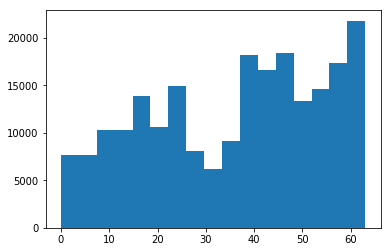

In [38]:
hist(activated_filters[2], bins=17)